In [0]:
!pip install kivy
!pip install torchsummary

     |████████████████████████████████| 28.3MB 1.2MB/s 
  Created wheel for Kivy-Garden: filename=Kivy_Garden-0.1.4-cp36-none-any.whl size=4532 sha256=8f031c791afcaabc591ecb7938ada5a41d1620b0cd968ed760de84c2764e3429
  Stored in directory: /root/.cache/pip/wheels/e5/09/36/4bec048252175b6aa7ba75441cbeed8f31a0bea37abedcfed0
Successfully built Kivy-Garden


In [0]:
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np 

## Image Cropper

In [0]:


'''
Since rotating the image with expand=1 which adds padding to the image 
with pixel value of 255 which we convert to 0 by masking white image and 
creating a composite image using alpha layer and convert the image to grayscale
'''
def rotate_grayscale_img(img, angle):
    img_1 = img.convert('RGBA')
    # rotated image
    img_rt = img_1.rotate(angle, expand=1)
    # a white image same size as rotated image
    white_mask = Image.new('RGBA', img_rt.size, (255,)*4)
    # create a composite image using the alpha layer of rot as a mask
    out = Image.composite(img_rt, white_mask, img_rt)
    return out.convert('L')

#pad the image with given x and y pixel
def pad(img, x, y):
    return np.pad(img, (x, y), 'constant',constant_values=255)

'''
Step1 : Convert the image to numpy array
Step2 : Get startx and starty cordinates from the x,y as image center subtracted by half crop size
Step3 : If startx and starty and less than or greater than image width and height pad the image with missing pixels
Step4 : Crop the image based on startx, stary, cropx, cropy values
'''
def crop_center(img, x, y, cropx=300, cropy=300):
    #convert image to numpy
    img_np = np.asarray(img)
    max_x, max_y = img_np.shape
    startx = int(x - (cropx//2))
    starty = int(y - (cropy//2))
    pad_x_0 = 0
    pad_x_1 = 0
    pad_y_0 = 0
    pad_y_1 = 0
    
    #Pad image if x, y coordinates are close to max, min coordinates 
    if startx < 0:
        pad_x_0 = -startx
        startx=0
    if (startx + cropx) > max_x:
        pad_x_1 = startx + cropx - max_x
    if starty < 0:
        pad_y_0 = -starty
        starty=0
    if (starty + cropy) > max_y:
        pad_y_1 = starty + cropy - max_y
        
    img_pad = pad(img_np, (pad_x_0, pad_x_1), (pad_y_0, pad_y_1))
    return Image.fromarray(img_pad[startx:startx+cropx, starty:starty+cropy])

'''
Step1: Crop Image taking x,y as center and cropping the image 5 time from the actual cropx and cropy value
Step2: Rotate the cropped image using defined angle and return gray scale image
Step3: Recrop the cropped image after rotation 3 times the actual crop values
Step4: Resize the image based on the size defined
''' 
def croppedImage(img, y, x, angle, size, cropx=200, cropy=200):
    img_crop = crop_center(img, x, y, np.multiply(cropx,5), np.multiply(cropy,5))
    img_crop_rt = rotate_grayscale_img(img_crop, angle)
    width, height = img_crop_rt.size 
    img_crop_1 =  crop_center(img_crop_rt, width/2,height/2,np.multiply(cropx,3),np.multiply(cropx,3))
    return img_crop_1.resize((size,size), Image.ANTIALIAS)

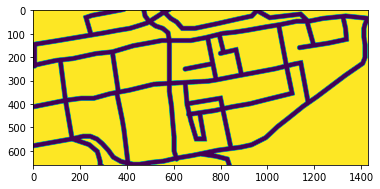

In [0]:
img = Image.open('MASK1.png').convert('L')
plt.imshow(img)

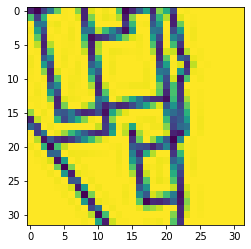

In [0]:
cropped_img = croppedImage (img, 1100, 150, -90, 32)
plt.imshow(cropped_img)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

## Environment

In [0]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

from kivy.vector import Vector

#Read map on which we are training our car to drive
img = Image.open('MASK1.png').convert('L')
#width and height of image
width, height = img.size
#this is to load initial data
sand = np.zeros((height, width))
sand = np.asarray(img)/255
first_update = True

'''
Default values to be loaded 
goal_x, goal_y target which the car as to reach from source
first_update: if true load initial data
sand : image mask used to validate sand and non sand values
swap: swap the destination once target reach
'''
def init():
    global sand
    global goal_x
    global goal_y
    global first_update
    goal_x = 800
    goal_y = 590
    first_update = False
    global swap
    swap = 0

# Initializing the last distance
last_distance = 0
last_reward = 0

'''
Autocar Environment where input to network is cropped image and 
output is angel using which we decide car direction
state_dim :  1 input (Cropped image) 
action_dim: 1 ouput (angle output from the network)
max_action (max angle range)
low and high (min and max noise)
x and y (car position)
randomCord : initialize x and y coordinates with random coordinates initially
'''
class AutoCarEnv(object):  
    def __init__(self):
        self.state_dim = 1
        self.action_dim = 1
        self._max_episode_steps = 10000
        self.velocity = (2, 0)
        self.done = 0
        self.max_action = 5
        self.low = -5
        self.high = 5
        self.angle = 0
        self.x = 0
        self.y = 0
        self.x_array = []
        self.y_array = []
        self.sandReward = 0
        self.nonsandReward = 0
        self.randomCord()

    def resetInfo (self):
        self.x_array = []
        self.y_array = []
        self.sandReward = 0
        self.nonsandReward = 0

    def plotData (self):
        plt.imshow(img,zorder=1)
        plt.scatter(self.x_array, self.y_array,zorder=2,s=1,c='red')
        # img1 = Image.open('white.png')
        # imscatter(self.x_array, self.y_array, img1, zoom=0.05)
        plt.show()

    def plotData_i (self, x, y, angle):
        plt.imshow(img,zorder=1)
        plt.scatter(x,y,zorder=2,s=1,c='red')
        plt.show()

    def printRewardDistribution (self):
      print('Sand ', self.sandReward, 'Non Sand', self.nonsandReward)
      
    #Random cordinates assigned to x and y initially or on reset
    def randomCord(self):
        np.random.seed(random.randint(0, 500))
        self.x = np.random.randint(10, high=width-10, size=1, dtype='l')[0]
        self.y = np.random.randint(10, high=height-10, size=1, dtype='l')[0]
        while sand[int(self.y),int(self.x)] > 0 :
          np.random.seed(random.randint(0, 500))
          self.x = np.random.randint(10, high=width-10, size=1, dtype='l')[0]
          self.y = np.random.randint(10, high=height-10, size=1, dtype='l')[0]

        

    #new car postion and angle based on output from then network
    def move(self, rotation):
        x,y = Vector(*self.velocity)
        self.x = x + self.x
        self.y = self.y - y
        self.angle = self.angle + rotation
    
    '''
    step to be taken to find the next state and assign reward based on the action taken
    input is action from the network used to calculate car direction
    if on sand assign negative reward of 2
    if not on sand assign living penalty reward of negative 0.2
    if not on sand and closer to destination assign postive reward of 0.5
    if hit the wall assign negative reward -10
    output is 
        next_state : next observation (cropped image) 
        reward : reward based on the action taken
        done : done to indicate if current action led to achieve required 
               target or hit a wall or 0 if exploring
        info : debug info
    '''
    def step(self, action):
        global goal_x
        global goal_y
        global last_reward
        global last_distance
        global swap

        if first_update:
            init()

        self.done = 0

        
        #difference between destination and current car coordinates
        xx = goal_x - self.x
        yy = goal_y - self.y
        self.move(action)
        
        
        orientation = Vector(*self.velocity).angle((xx, yy))/180.
        distance = np.sqrt((self.x - goal_x)**2 + (self.y - goal_y)**2)
        if sand[int(self.y),int(self.x)] > 0:
            self.velocity = Vector(0.5, 0).rotate(self.angle)
            last_reward = -1
            self.sandReward = self.sandReward + last_reward
        else:
            self.velocity = Vector(2, 0).rotate(self.angle)
            last_reward = -0.1
            self.nonsandReward = self.nonsandReward + last_reward
            if distance < last_distance:
              last_reward = 0.5

        #if car hits the wall assign high penalty and done = 1
        if (self.x < 5 or self.x > width - 5 or self.y < 5 or self.y > height - 5):
            print('crashed', self.x, self.y)
            self.plotData()
            self.done = 1
            last_reward = -5

        #swap the destination once car reaches current destination
        if distance < 25:
            print('Destination', self.x, self.y)
            last_reward = 100
            self.done = 1
            if swap == 1:
                goal_x = 800
                goal_y = 400
                swap = 0
            else:
                goal_x = 100
                goal_y = 560
                swap = 1
        last_distance = distance
        
        # cropped image with center x,y and output size 32 and rotate angle to align with car direction
        self.x_array.append(self.x)
        self.y_array.append(self.y)
        cropped_image = croppedImage(img, self.x, self.y, self.angle, 32)
        # print(self.x, self.y)
        # plt.imshow(cropped_image)
        # plt.show()
        # self.plotData_i(self.x, self.y, self.angle)
        #return cropped image, reward acheived for the action taken 

        #print('action', action,'orientation', orientation, 'angle',  vel.angle(Vector(1,0))/180)
        return np.asarray(cropped_image)/255, np.asarray([orientation, -orientation]), last_reward, self.done, {}

    # return random angle rangign min to max
    def sample(self):
        return np.random.randint(-5, 5, size=1)[0]

    #reset environment with default and new random x,y coordinates and cropped image with x,y has center
    def reset(self):
        self.randomCord()
        cropped_image = croppedImage(img, self.x, self.y, 0, 32)
        return np.asarray(cropped_image)/255, np.asarray([0, 0])

    #random seed value
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

[WARNING] [Config      ] Older configuration version detected (0 instead of 21)
[WARNING] [Config      ] Upgrading configuration in progress.
[INFO   ] [Logger      ] Record log in /root/.kivy/logs/kivy_20-05-07_0.txt
[INFO   ] [Kivy        ] v1.11.1
[INFO   ] [Kivy        ] Installed at "/usr/local/lib/python3.6/dist-packages/kivy/__init__.py"
[INFO   ] [Python      ] v3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
[INFO   ] [Python      ] Interpreter at "/usr/bin/python3"


In [0]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from collections import deque
from torchsummary import summary

## Step 1: We initialize the Experience Replay memory

In [0]:
class ReplayBuffer(object):
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, transition):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = transition
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(transition)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        batch_states, batch_next_states, batch_orientation, batch_next_orientation, batch_actions, batch_rewards, batch_dones = [], [], [], [], [], [], []
        for i in ind: 
            state, next_state, orientation, next_orientation, action, reward, done = self.storage[i]
            batch_states.append(np.array(state, copy=False))
            batch_next_states.append(np.array(next_state, copy=False))
            batch_orientation.append(np.array(orientation, copy=False))
            batch_next_orientation.append(np.array(next_orientation, copy=False))
            batch_actions.append(np.array(action, copy=False))
            batch_rewards.append(np.array(reward, copy=False))
            batch_dones.append(np.array(done, copy=False))
        return np.array(batch_states), np.array(batch_next_states), np.array(batch_orientation), np.array(batch_next_orientation), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

In [0]:
def conv2d_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout2d(0.1))

def transition_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.1))

In [0]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: We build one neural network for the Actor model and one neural network for the Actor target

In [0]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=state_dim, out_channels=16, kernel_size=(3, 3), padding=0), 
            nn.ReLU()) 
        self.convblock2 = conv2d_block(in_channels=16, out_channels=10)
        self.transitionblock = transition_block(in_channels=10, out_channels=10)
        self.convblock3 = conv2d_block(in_channels=10, out_channels=10)
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.fc1 = nn.Linear(12, 10)
        self.fc2 = nn.Linear(10, 1)
        self.max_action = max_action

    def forward(self, x, y):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transitionblock(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = torch.flatten(x, 1)
        x = torch.cat([x, y], 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.max_action * torch.tanh(x)
        return x

In [0]:
model = Actor(1,1,1).to(device)
#summary(model, input_size=[(1,32,32), (2,)])

## Step 3: We build two neural networks for the two Critic models and two neural networks for the two Critic targets

In [0]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=state_dim, out_channels=16, kernel_size=(3, 3), padding=0), 
            nn.ReLU()) 
        self.convblock2 = conv2d_block(in_channels=16, out_channels=10)
        self.transitionblock1 = transition_block(in_channels=10, out_channels=10)
        self.convblock3 = conv2d_block(in_channels=10, out_channels=10)
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.avgPool2d1 = nn.AvgPool2d(9)
        self.fc1 = nn.Linear(10+3, 10)
        self.fc2 = nn.Linear(10, 1)
        # Defining the second Critic neural network
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=state_dim, out_channels=16, kernel_size=(3, 3), padding=0), 
            nn.ReLU()) 
        self.convblock6 = conv2d_block(in_channels=16, out_channels=10)
        self.transitionblock2 = transition_block(in_channels=10, out_channels=10)
        self.convblock7 = conv2d_block(in_channels=10, out_channels=10)
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.avgPool2d2 = nn.AvgPool2d(9)
        self.fc3 = nn.Linear(10 + 3, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x, y, u):
        # Forward-Propagation on the first Critic Neural Network
        x1 = self.convblock1(x)
        x1 = self.convblock2(x1)
        x1 = self.transitionblock1(x1)
        x1 = self.convblock3(x1)
        x1 = self.convblock4(x1)
        x1 = F.adaptive_avg_pool2d(x1, (1,1)) 
        x1 = torch.flatten(x1, 1)
        x1 = torch.cat([x1, y], 1)
        x1 = torch.cat([x1, u], 1)
        x1 = self.fc1(x1)
        x1 = F.relu(x1)
        x1 = self.fc2(x1)
        # Forward-Propagation on the second Critic Neural Network
        x2 = self.convblock5(x)
        x2 = self.convblock6(x2)
        x2 = self.transitionblock2(x2)
        x2 = self.convblock7(x2)
        x2 = self.convblock8(x2)
        x2 = F.adaptive_avg_pool2d(x2, (1,1))
        x2 = torch.flatten(x2, 1)
        x2 = torch.cat([x2, y], 1)
        x2 = torch.cat([x2, u], 1)
        x2 = self.fc1(x2)
        x2 = F.relu(x2)
        x2 = self.fc2(x2)
        return x1, x2

    def Q1(self, x, y, u):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transitionblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = torch.flatten(x, 1)
        x = torch.cat([x, y], 1)
        x = torch.cat([x, u], 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## Steps 4 to 15: Training Process

In [0]:
# Building the whole Training Process into a class

class TD3(object):
  
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
        self.max_action = max_action

    def select_action(self, state, orientation):
        state = torch.Tensor(state).to(device)
        state = state.unsqueeze(0).unsqueeze(0)

        orientation = torch.Tensor(orientation.reshape(1, -1)).to(device)
        return self.actor(state, orientation).cpu().data.numpy().flatten()

    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
        for it in range(iterations):
      
            # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
            batch_states, batch_next_states, batch_orientation, batch_next_orientation, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
            state = torch.Tensor(batch_states).to(device)
            next_state = torch.Tensor(batch_next_states).to(device)
            orientation = torch.Tensor(batch_orientation).to(device)
            next_orientation = torch.Tensor(batch_next_orientation).to(device)
            action = torch.Tensor(batch_actions).to(device)
            reward = torch.Tensor(batch_rewards).to(device)
            done = torch.Tensor(batch_dones).to(device)

            next_state = next_state.unsqueeze(1)
            state = state.unsqueeze(1)
            
            # Step 5: From the next state s’, the Actor target plays the next action a’
            next_action = self.actor_target(next_state, next_orientation).squeeze(1)
            
            # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
            noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (next_action + noise).clamp(-self.max_action, self.max_action).unsqueeze(1)
            
            # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
            target_Q1, target_Q2 = self.critic_target(next_state, next_orientation, next_action)

            # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
            target_Q = torch.min(target_Q1, target_Q2)

            # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
            target_Q = reward + ((1 - done) * discount * target_Q).detach()

            # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
            current_Q1, current_Q2 = self.critic(state, orientation, action.unsqueeze(1))

            # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
            if it % policy_freq == 0:
                actor_loss = -self.critic.Q1(state, orientation, self.actor(state, orientation)).mean()
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    # Making a save method to save a trained model
    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

## We set the parameters

In [0]:
env_name = "AutoCarEnv" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.5 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 1 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated

## We create a file name for the two saved models: the Actor and Critic models

In [0]:
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

---------------------------------------
Settings: TD3_AutoCarEnv_0
---------------------------------------


## We create a folder inside which will be saved the trained models

In [0]:
if not os.path.exists("./results"):
    os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
    os.makedirs("./pytorch_models")

## We create the AutoCar environment

In [0]:
env = AutoCarEnv()

## We set seeds and we get the necessary information on the states and actions in the chosen environment

In [0]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.state_dim
action_dim = env.action_dim
max_action = env.max_action

  ## We create the policy network (the Actor model)

In [0]:
policy = TD3(state_dim, action_dim, max_action)

## We create the Experience Replay memory

In [0]:
replay_buffer = ReplayBuffer()

## We initialize the variables

In [0]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

## Training

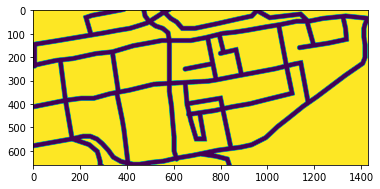

Sand  0 Non Sand 0
[]
crashed 1424.1155750371322 23.237501364185512


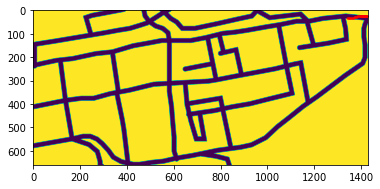

[1, 4, -4, -3, 3, -3, -5, 4, 3, 3, 4, 0, 2, 3, 3, 1, 2, 4, -2, -1, -5, -1, 3, -3, -3, 2, 2, -2, -4, 0, -5, -1, -4, -3, 0, -5, 4, 3, 4, -3, -1, 3, 1, -5, 1, -5, -3, 4, 0, 3, 4, -2, -1, 2, 1, -2, -5, 3, 0, 0, 2, 1, 2, 1, -1, 4, 2, 2, 0, 1, 0, 4, -2, 4, 2, -5]
Total Timesteps: 76 Episode Num: 1 Reward: -51.2
crashed 1424.024038491717 240.52738744870447


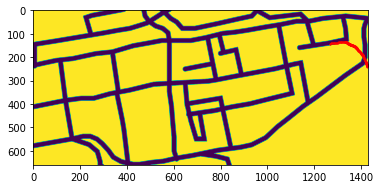

[4, 0, 0, -5, 0, 0, 1, -5, -4, -1, 3, 4, -1, -5, -2, -2, 4, 3, 1, -3, 2, -3, -1, 1, -1, -3, -2, 4, -1, 0, -5, 2, 0, 3, 0, 2, 1, -1, -5, 1, -5, -5, 1, -2, -5, 2, -4, 1, -5, -5, 3, 0, -4, -2, -1, -5, -3, 4, -2, 4, 2, -2, 0, 4, -5, 3, 0, 0, 2, 4, -1, 4, 1, -3, 2, -5, -3, 1, -2, 0, 4, 2, 0, 3, -1, -1, 0, -4, 1, 2, 0, 1, -2, 3, 4, -3, 2, 1, 4, -5, 4, 1, 1, -2, 3, 0, 1, 0, -1, -4, -3, -3, -1, 2, 3, -3, -5, -2, 2, -2, -5, -4, 2, -1, -3, -4, -2, 4, 3, 2, 4, -3, -3, -1, 1, -5, -3, -3, 2, -2, 1, 2, 4, 4, -5, 1, 4, -2, -5, 3, -4, -5, 4, -3, 0, -4, 0, 3, -2, -1, 0, 3, -2, 4, -1, 4, 4, -3, 4, -4, 2, 3, 0, 4, -2, 3, -1, -3, 1, -5, 1, -1, 1, 1, -3, -1, 2, 3, 1, 0, -1, -1, -2, -3, -3, 3, 2, -3, 4, -5, -5, 4, 2, -2, 4, -4, 2, -2, -4, -1, 4, 0, -5, 0, 3, -2, 0, 4, -2, 4, 0, -2, 1, -4, 4, -4, -4, -3, 0, 2, 3, -5, -4, 0, 1, -4, 2, 2, -2, 2, 4, 2, -4, 0, 1, -1, 4, 2, -4, -5, -1, -2, -3, -5, -4, 1, 1, 2, -3, 3, -3, 2, -2, -5, -1, -5, 4, 4, -3, 0, -1, 0, 1, 1, 2, 1, 3, -5, -4, 4, 2, 2, 0, 4, 1, -3, -1, -5]
T

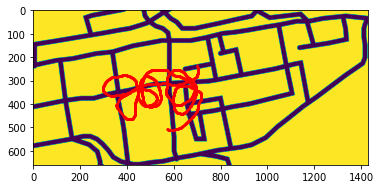

Sand  -4171 Non Sand -46.50000000000039


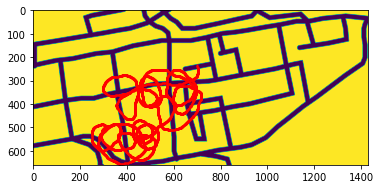

Sand  -9020 Non Sand -61.600000000000605


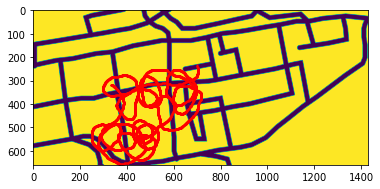

[0, 4, -1, 3, -4, -1, 2, -2, -2, 4, 2, 2, 0, -5, -4, -5, -1, -3, -2, 4, -2, 4, 0, 2, -4, 0, 3, 2, -5, 4, 3, -5, -4, -3, 1, 4, -3, 1, -5, 1, 1, 2, -2, 2, 1, -1, -3, -4, -3, 2, 3, 0, 3, -1, -2, 1, 0, 0, 3, -4, 2, -2, -3, -1, -2, -1, -4, -2, -2, -2, -3, -5, -3, -5, 0, -2, 4, -5, -2, -3, -3, 3, -1, 1, -1, 0, 3, 2, 1, 1, -4, 0, -5, 4, 2, 4, -1, 1, 4, -2, -2, -5, -3, -3, -2, 2, -1, 0, -1, 1, -4, 2, 4, -1, 1, 1, -5, -1, -5, -5, 2, 1, -2, -3, -4, -1, 4, -1, 0, -1, -1, 4, 0, 2, 4, 4, 4, -2, -5, -3, 0, 3, -3, 4, -4, 1, -3, -4, 0, 0, 0, -4, -4, -5, 3, 0, -1, -2, 2, 2, -2, -2, 4, 0, -2, -5, -3, -5, -5, 4, -5, 3, -1, -1, -1, 2, -4, -3, 4, 3, -1, 1, 4, 4, 3, 3, 0, 0, 4, 4, -2, -1, -4, 4, -3, -2, -2, 3, -3, 2, -2, 1, 0, 2, -3, -4, 4, 0, -3, 4, 3, 2, 1, 0, 4, -5, 2, 3, -4, -3, 2, 0, 1, 3, 4, 3, -2, -2, 4, 2, -2, 0, 3, -1, -1, 0, -2, 3, -4, 3, 2, -5, 0, 3, 4, 4, 4, 4, 0, -2, -1, 2, -1, -2, -1, 2, -5, 4, 4, 1, 3, 0, -1, 3, -5, 4, -4, -4, -3, -5, -4, 0, -3, 4, 4, 4, 0, 3, -3, 0, -2, -5, -5, 2, -2, 1, -2,

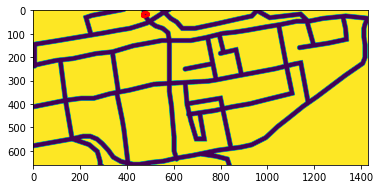

[-4.923372924577618, -4.756001622795271, -5.0, -4.624090646247617, -5.0, -4.911472682677252, -4.801839607226937, -4.309550058795963, -4.707527515413897, -4.240489854219858, -5.0, -4.943414308372107, -4.964789165072816, -4.77576098313034, -4.4534520504717525, -5.0, -5.0, -4.5250723268988295, -4.379613831830942, -4.826814886305002, -5.0, -5.0, -5.0, -5.0, -4.914795304028541, -4.997895451843316, -4.767704819484782, -5.0, -5.0, -5.0, -4.788774354215118, -4.174075262470759, -5.0, -4.25976664429116, -5.0, -4.616316645811918, -4.507645407270417, -5.0, -4.402396911106058, -5.0, -4.416881742147709, -5.0, -4.192711063394091, -4.323409240234803, -4.520316057117984, -5.0, -4.6594826441770785, -4.69961495896376, -5.0, -5.0, -3.9635896417681824, -4.934877305578643, -4.9294965185844255, -4.5692898693309525, -5.0, -4.981985199840241, -5.0, -5.0, -5.0, -4.67613958481563, -4.991727220895786, -4.895694797535842, -4.681958225385701, -3.9725563105468558, -4.488508332740574, -5.0, -4.889446986214908, -5.0, 

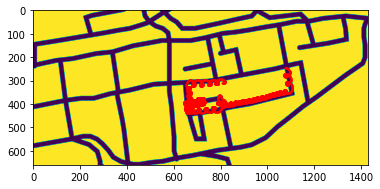

Sand  -3341 Non Sand -118.69999999999753


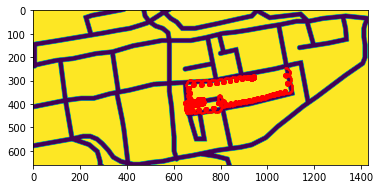

Sand  -8244 Non Sand -128.399999999997


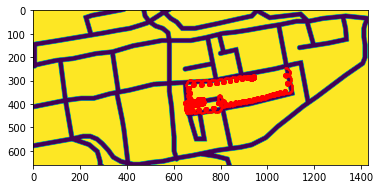

[-5.0, -5.0, -5.0, -5.0, -5.0, -4.425246771087773, -5.0, -4.675228928784767, -5.0, -4.108163920607813, -5.0, -4.904287371229421, -4.45029760276375, -5.0, -4.373931936747912, -4.559388477630407, -4.4855736202442165, -4.805136677731697, -3.808623730318261, -4.606552633751435, -4.205953827285588, -5.0, -5.0, -4.313618756956244, -4.908593883684927, -4.725547359764384, -4.373621750496329, -4.871180023806116, -5.0, -5.0, -5.0, -4.506761677652497, -4.87150582548942, -5.0, -4.801157359049302, -5.0, -4.726795042161669, -5.0, -5.0, -4.727692285846411, -4.040860999323769, -5.0, -5.0, -4.962269285596601, -3.8922708819326384, -4.695435306561296, -4.581840370664571, -4.917028577839399, -4.50436578417879, -4.845549493034286, -5.0, -4.3202784161564445, -4.324918652634992, -5.0, -4.6608247083540215, -4.784648240137763, -4.277263791640738, -4.62651800784453, -5.0, -5.0, -5.0, -4.51347935941793, -4.933892326214291, -4.861534261657445, -5.0, -4.8398012006199, -5.0, -4.666878323669152, -5.0, -4.21034839687

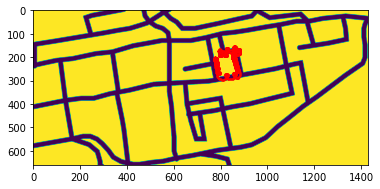

Sand  -4115 Non Sand -41.40000000000032


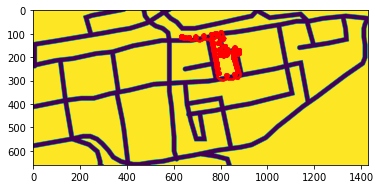

Sand  -8663 Non Sand -86.59999999999935


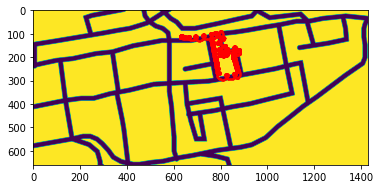

[-4.9525713003856096, -4.9266359689735175, -5.0, -5.0, -5.0, -5.0, -4.865739572805314, -5.0, -4.18296622250684, -5.0, -5.0, -4.995806174137184, -4.9523168379868086, -5.0, -4.951497182338657, -5.0, -4.519976797777393, -5.0, -4.548476407317958, -4.604060173582723, -5.0, -4.662767090318123, -5.0, -5.0, -4.759568756661826, -4.819657856362836, -4.206735238652686, -4.903099425427526, -4.192407103651148, -5.0, -4.523860476814463, -4.671802377726009, -5.0, -3.994914214367057, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.988696316035441, -5.0, -5.0, -4.631876010438603, -5.0, -5.0, -5.0, -5.0, -4.777762691471647, -4.724054204849111, -4.910331974752735, -3.9316211137415786, -4.328156542343543, -4.968019717452543, -4.687254952760826, -5.0, -4.565838659701477, -4.754382958000405, -5.0, -5.0, -4.272044402593777, -4.622946334062004, -5.0, -4.9238166638050105, -4.298726971114191, -5.0, -5.0, -4.898124515676287, -4.917799817915547, -3.783933877689064, -4.59439902211964, -5.0, -3.7449226995699236, -4.99307319

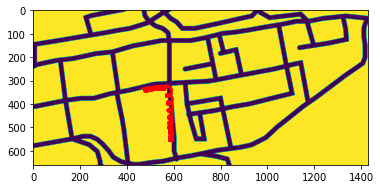

Sand  -4287 Non Sand -24.300000000000075


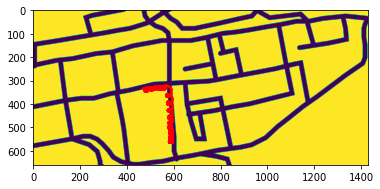

Sand  -9280 Non Sand -25.000000000000085


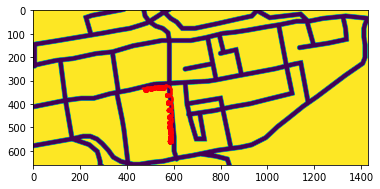

[-4.916697191028529, -5.0, -4.069716248727559, -5.0, -4.787279643739491, -5.0, -4.925215860104657, -5.0, -5.0, -4.433019310849683, -4.986802435327676, -5.0, -4.849403127440554, -4.976331859359457, -4.6592842730432436, -5.0, -5.0, -5.0, -4.909794748430982, -4.82197283298977, -5.0, -4.559333825418414, -5.0, -4.800045943265508, -5.0, -4.685836038865061, -4.465109367204513, -5.0, -4.616409631538388, -4.714424279600636, -4.481081570580796, -5.0, -5.0, -5.0, -4.796731178921317, -5.0, -5.0, -5.0, -4.865194591956836, -5.0, -4.830438174279729, -5.0, -5.0, -4.762746629534252, -5.0, -4.5449782853416085, -5.0, -4.1972770063421985, -4.367674171145289, -5.0, -4.7250049986993305, -4.263820180217652, -5.0, -5.0, -4.884142238167531, -5.0, -4.924099929763465, -5.0, -5.0, -3.5805304106132825, -5.0, -4.953918960829979, -4.688446197903089, -4.508800982390645, -4.628975921510941, -4.332882870542692, -5.0, -5.0, -5.0, -4.672446840243321, -4.554836579528552, -4.109711294295114, -5.0, -4.654793015819261, -5.0,

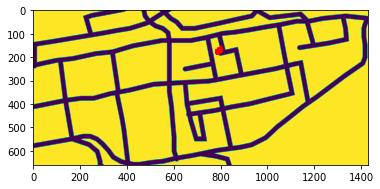

Sand  -4515 Non Sand -1.6000000000000003


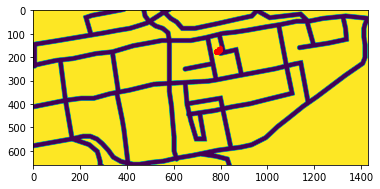

Sand  -9515 Non Sand -1.6000000000000003


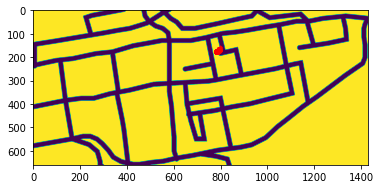

[-5.0, -5.0, -5.0, -4.827183285710244, -5.0, -4.935962539201089, -4.4625851372657, -5.0, -5.0, -4.964137662556493, -5.0, -5.0, -4.973542367201482, -4.482176475002687, -5.0, -3.637253396012813, -5.0, -5.0, -4.938781714755051, -4.820697290453342, -4.652063058194938, -4.964186325373057, -4.025995506893715, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.090060592480814, -4.95211007067005, -5.0, -4.807457564918466, -4.83519410169542, -4.554671516430467, -5.0, -4.760772187890425, -5.0, -4.625394854154815, -5.0, -5.0, -5.0, -5.0, -5.0, -4.546378689401598, -4.905085892687264, -4.936942702810916, -5.0, -5.0, -4.694031611078979, -4.508183276406737, -5.0, -5.0, -5.0, -5.0, -5.0, -4.97854358872453, -5.0, -5.0, -5.0, -5.0, -5.0, -4.696870037078176, -5.0, -4.911652072188408, -5.0, -5.0, -4.4008917187943055, -5.0, -5.0, -4.2426871951419685, -3.814254572719662, -4.939495629176975, -4.3984982385759315, -5.0, -5.0, -5.0, -4.721739951816926, -4.838968227630206, -3.7433317749749575, -4.9941241301922465, -5.0, -4.

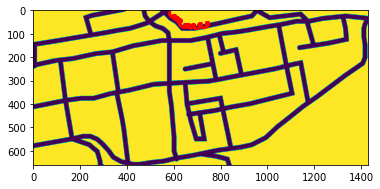

[-4.640058514637093, -4.453613760152185, -4.516667408231234, -5.0, -4.927134480383396, -5.0, -4.715402392172703, -4.741226414398274, -5.0, -4.791104358451949, -5.0, -4.976359714757564, -4.219626689322743, -5.0, -5.0, -4.167562781377463, -5.0, -5.0, -5.0, -5.0, -5.0, -4.316360409689945, -4.345643753168828, -5.0, -4.870277967718973, -4.9567726557017595, -4.595251222128534, -5.0, -4.847421727980191, -5.0, -4.91039100978676, -4.775522171943849, -4.085492504613614, -5.0, -4.986152148550768, -5.0, -4.725895048496511, -4.8207605605096795, -4.405700784860074, -4.872624814856326, -5.0, -4.68827494660953, -4.374486377946228, -4.277673984926434, -5.0, -4.535587006166446, -4.901474149264196, -5.0, -5.0, -5.0, -5.0, -5.0, -4.2309291804341544, -5.0, -5.0, -4.326485123021101, -4.905865882970275, -5.0, -4.811361246198442, -4.479728265069625, -5.0, -4.540267317630742, -5.0, -5.0, -5.0, -4.562175114609225, -4.50754192486367, -5.0, -5.0, -4.514812440875423, -5.0, -5.0, -4.9445992004033705, -5.0, -5.0, -5

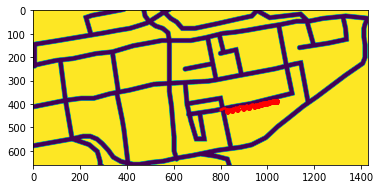

Sand  -3744 Non Sand -16.99999999999997


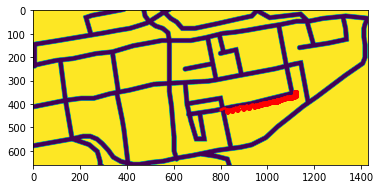

Sand  -8676 Non Sand -23.800000000000068


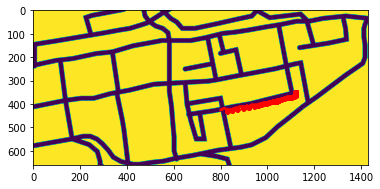

[-5.0, -4.167170729567172, -4.189223498751558, -4.726739919894729, -4.845299659453673, -5.0, -4.573534914486911, -3.8928998308366367, -4.893330076104436, -4.283521224087271, -5.0, -5.0, -5.0, -5.0, -5.0, -4.665075865855165, -4.06720604209685, -5.0, -4.893498229296483, -4.847209240388144, -5.0, -5.0, -5.0, -5.0, -4.341488368817887, -5.0, -5.0, -5.0, -4.862696746953508, -5.0, -4.540920043220457, -4.694165119402316, -5.0, -5.0, -5.0, -5.0, -4.306530633091025, -5.0, -4.910007647166931, -4.902981982448011, -5.0, -5.0, -5.0, -4.647172720358947, -4.744076617487573, -5.0, -5.0, -5.0, -4.772451750855478, -4.169608045989708, -5.0, -5.0, -5.0, -4.462145889729191, -5.0, -4.8530127798294656, -4.644634972033631, -4.472532500743881, -4.474679029158606, -4.766592315820679, -4.14246040076271, -4.974791720471737, -5.0, -4.978208374697779, -5.0, -5.0, -5.0, -5.0, -5.0, -4.282389619322057, -4.927953116883344, -5.0, -4.592091502097535, -5.0, -4.870428344915365, -5.0, -4.839238921764985, -5.0, -4.4537655605

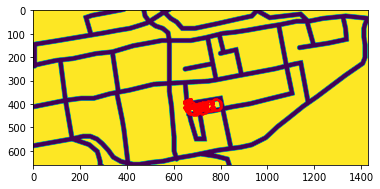

Sand  -3480 Non Sand -43.50000000000035


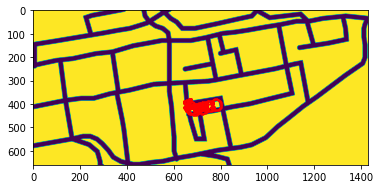

Sand  -8480 Non Sand -43.50000000000035


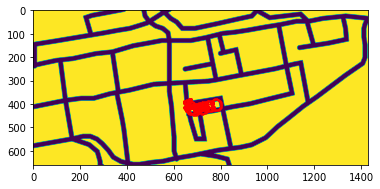

[5.0, 4.810902026537744, 5.0, 5.0, 4.591379987541304, 4.95925838809106, 5.0, 4.761846229493828, 5.0, 5.0, 5.0, 4.693391271748014, 4.54761532432287, 5.0, 5.0, 5.0, 4.931196874509547, 4.839448655103891, 5.0, 5.0, 5.0, 4.910783727671345, 5.0, 5.0, 5.0, 4.451618239046036, 5.0, 5.0, 4.362272283200765, 5.0, 5.0, 4.35622108346696, 4.9311537079958905, 5.0, 5.0, 5.0, 5.0, 4.944993308962249, 4.963536976544372, 5.0, 5.0, 5.0, 4.66431834292644, 5.0, 5.0, 3.8136874381025376, 5.0, 4.994187218609816, 4.473781056009466, 5.0, 4.944142546096523, 4.295314241374634, 4.652715479922626, 5.0, 5.0, 4.591276628231338, 5.0, 4.87786825466384, 5.0, 5.0, 3.99956111099854, 4.195394376212896, 5.0, 4.920013421602005, 5.0, 5.0, 4.669463916299684, 4.835110143156041, 5.0, 5.0, 5.0, 5.0, 5.0, 4.980538632703187, 5.0, 4.834780569590044, 4.00385971469127, 4.856343849869031, 4.768418810777368, 5.0, 4.262518682963239, 4.800362458777478, 5.0, 4.949488932851748, 5.0, 5.0, 4.225699607474051, 4.586671008859011, 5.0, 4.86056589284

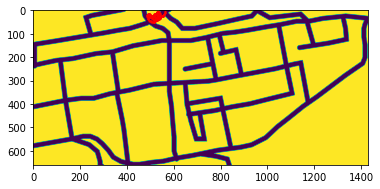

[5.0, 5.0, 5.0, 5.0, 4.907498105607625, 5.0, 4.843890699757074, 4.881566003795347, 5.0, 5.0, 4.811409900520321, 5.0, 5.0, 5.0, 4.569396881182634, 5.0, 5.0, 4.661694063499651, 5.0, 4.507852150469948, 4.928073843168626, 4.723028082565541, 4.168360812769868, 4.511938335413481, 4.5398873515616724, 4.667953513507632, 5.0, 4.957064435662213, 4.835398851167879, 5.0, 5.0, 4.6529292339465425, 4.647506148194429, 4.2268901604006555, 5.0, 4.747669374883698, 5.0, 5.0, 4.821567803395909, 4.257026555803495, 5.0, 4.588766509423577, 5.0, 5.0, 4.981308512671243, 5.0, 5.0, 5.0, 5.0, 4.674227714474262, 4.560853335832663, 4.238445310813564, 4.799830987982817, 3.7054071619880657, 4.452367956314289, 4.885710608088923, 5.0, 4.662301849649598, 4.582757818066909, 4.855448814301121, 5.0, 4.7234217948203945, 5.0, 5.0, 4.326659677808423, 5.0, 4.3531444867128055, 4.833336175394077, 4.925140288796043, 5.0, 4.462937735743864, 4.849102615904863, 4.915571838895924, 4.296776183577688, 4.95426772656201, 3.898208986148572

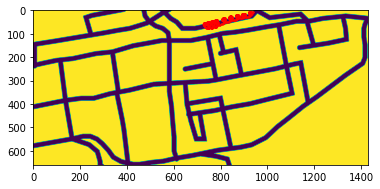

[5.0, 5.0, 5.0, 4.765430735917088, 5.0, 3.901422066252665, 5.0, 5.0, 4.700493835076704, 5.0, 4.686760734722457, 5.0, 5.0, 4.491987885838263, 4.269040257740304, 5.0, 4.731888927937326, 4.610257955678217, 4.532992574081408, 4.834412543030176, 4.432102451853942, 5.0, 5.0, 4.983873317907109, 5.0, 5.0, 5.0, 4.4994195586122885, 5.0, 4.933103898988679, 5.0, 5.0, 5.0, 4.568336675003882, 5.0, 4.567634152903201, 5.0, 5.0, 5.0, 5.0, 4.71389614571461, 5.0, 5.0, 5.0, 3.6844210107676276, 5.0, 5.0, 4.503119574131617, 4.786373504236906, 4.073852806704018, 4.560166631860487, 4.039874299071773, 5.0, 4.9770607110816, 4.753958492680956, 5.0, 5.0, 4.591190402467596, 5.0, 5.0, 4.9434493192619176, 5.0, 4.366654528876464, 4.784341299182477, 4.785315042234309, 5.0, 5.0, 4.9125816056393665, 4.492902100755197, 5.0, 4.536735280348027, 4.6349148007802485, 5.0, 4.898513816481357, 4.322107100279554, 4.469212407421026, 4.91295671306926, 5.0, 4.400098903650854, 4.796883679710869, 4.728515712861991, 4.777393772073279, 

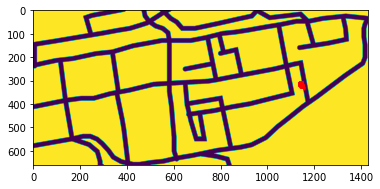

Sand  -2903 Non Sand -1.5000000000000002


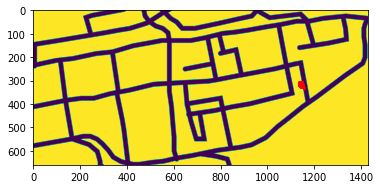

Sand  -7903 Non Sand -1.5000000000000002


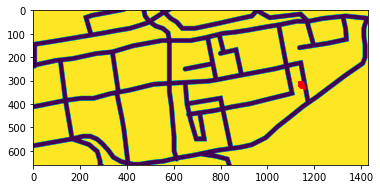

[5.0, 4.807240589250224, 4.5045065802638575, 5.0, 5.0, 5.0, 5.0, 4.921396256310716, 4.9079035366014745, 4.572729109157128, 4.965255041954638, 4.87337050336052, 5.0, 3.478522100324306, 3.9557330624141933, 4.778379365696934, 5.0, 4.666523249820572, 5.0, 5.0, 4.720466632784355, 5.0, 5.0, 4.481161615636935, 5.0, 4.745325748920392, 4.740220252384749, 4.537067703567035, 5.0, 4.528815156627246, 4.93975706351124, 4.626846049856952, 5.0, 5.0, 5.0, 4.686881157937356, 4.034043887770344, 3.792097169245499, 5.0, 4.550929335566256, 4.752363121706283, 4.445675064461824, 4.630612306389885, 5.0, 5.0, 5.0, 5.0, 4.91291249470645, 4.865264189625717, 4.492939879862984, 5.0, 4.240806073425857, 4.589024327440344, 5.0, 5.0, 5.0, 5.0, 4.856549908813885, 4.657357592122441, 4.300495063688971, 4.437326078889002, 5.0, 4.2651645141255035, 4.396177041863397, 5.0, 5.0, 4.954822104671678, 5.0, 5.0, 5.0, 5.0, 5.0, 4.548260832884923, 5.0, 4.223787751747701, 5.0, 5.0, 5.0, 5.0, 4.855948438361507, 4.784451763149161, 4.774

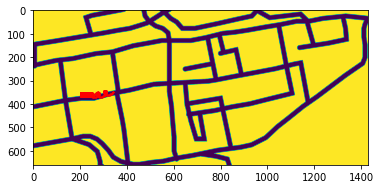

Sand  -2823 Non Sand -9.599999999999982


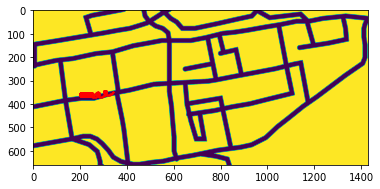

Sand  -7823 Non Sand -9.599999999999982


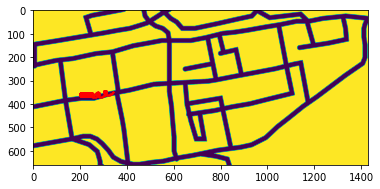

[-4.815836116729659, -4.639280384964038, -4.951310762672817, -4.965862991825371, -5.0, -4.477274906281998, -4.5234612713023346, -5.0, -4.433589337969995, -5.0, -4.982817787619286, -5.0, -4.523984670987411, -5.0, -4.418531565587542, -3.8553164862730256, -4.985281409176433, -4.580246423401103, -4.791007276555159, -5.0, -5.0, -4.046789893477976, -4.722905851827588, -5.0, -5.0, -5.0, -5.0, -5.0, -4.215318321348666, -5.0, -4.820466556894697, -4.633682962450823, -5.0, -5.0, -4.674155270317514, -5.0, -5.0, -4.952101468386166, -4.060269984527372, -4.781794988780138, -5.0, -4.980407174301991, -5.0, -5.0, -5.0, -5.0, -4.18178564001424, -5.0, -4.83888456540162, -5.0, -4.326349142129246, -4.9034497593907735, -5.0, -3.950691194685129, -5.0, -4.206606636588888, -4.976820983864237, -4.898214160723014, -5.0, -5.0, -4.738065567774804, -5.0, -4.332673374260721, -4.9689175090951485, -5.0, -4.954855098654442, -5.0, -4.799459497139963, -4.67981858645932, -4.124273476381116, -4.414243966446137, -4.707812944

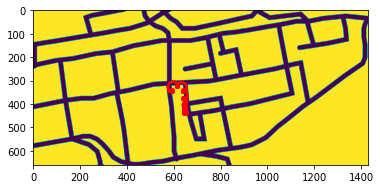

Sand  -2727 Non Sand -17.299999999999976


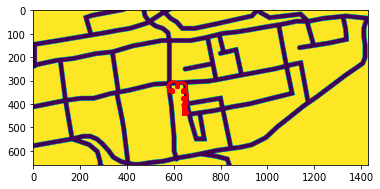

Sand  -7727 Non Sand -17.299999999999976


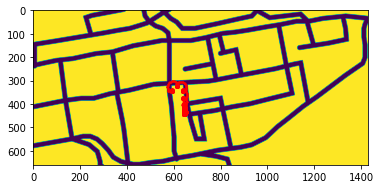

[-4.5487471987804895, -5.0, -5.0, -5.0, -5.0, -4.186693280538781, -4.573365494726171, -4.827989051527587, -5.0, -4.402717531366853, -5.0, -4.204450729777956, -4.892528101437275, -3.9150267599199067, -4.008250854059996, -5.0, -5.0, -5.0, -5.0, -4.920573769560453, -4.819616506367835, -4.915064427535411, -5.0, -4.966212654529395, -5.0, -4.263324896798588, -5.0, -5.0, -4.5487580670406595, -5.0, -4.777422571252053, -5.0, -5.0, -4.751101845276189, -4.402940464513918, -4.875887896483349, -4.709007878381791, -4.066380220384585, -4.309203218883973, -5.0, -5.0, -4.993877263299377, -5.0, -4.2209604675234775, -5.0, -5.0, -5.0, -4.403305426795869, -4.524685627408891, -5.0, -4.934089353973495, -5.0, -4.700709792556724, -5.0, -4.370521729493882, -5.0, -5.0, -4.960030866292405, -5.0, -5.0, -5.0, -4.736261715120241, -5.0, -5.0, -5.0, -5.0, -5.0, -4.448082433439614, -4.250542763027774, -5.0, -4.90606751784617, -4.423315587178505, -4.9192145725081815, -5.0, -5.0, -4.664889087354181, -4.822060968839071, -

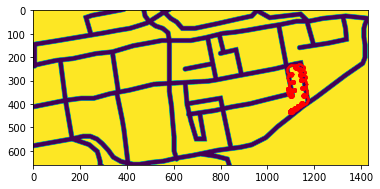

Sand  -2509 Non Sand -39.20000000000029


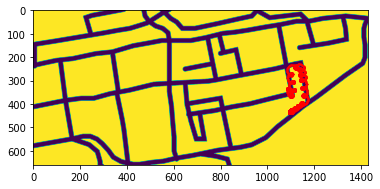

Sand  -7509 Non Sand -39.20000000000029


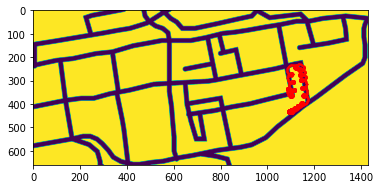

[-4.485683643860366, -5.0, -3.467584244822773, -5.0, -5.0, -4.67447334923448, -5.0, -5.0, -5.0, -4.483370395929841, -5.0, -5.0, -5.0, -5.0, -5.0, -4.46293156664411, -4.826952785597737, -4.560386495985024, -4.791876685621701, -4.542484456253139, -4.945719298102247, -5.0, -4.66446489083613, -5.0, -3.889893231556875, -4.998923564901667, -5.0, -5.0, -5.0, -5.0, -4.588886362777156, -5.0, -4.768674580223086, -4.994988692374382, -5.0, -5.0, -5.0, -5.0, -4.468373457998373, -5.0, -4.737712230334541, -4.16452736274187, -5.0, -5.0, -4.434607826076322, -4.980109912691622, -5.0, -5.0, -4.508828010309748, -5.0, -5.0, -5.0, -4.785660393560469, -4.247199896194038, -4.904167445111381, -5.0, -4.88197566505649, -4.354745675833291, -5.0, -5.0, -5.0, -3.9394208022826303, -4.7275751384870315, -5.0, -5.0, -4.588437403451136, -5.0, -4.98925907513838, -5.0, -4.741086140449391, -4.535893705678724, -4.349958008147106, -4.906419642598338, -5.0, -4.687501176248103, -4.79700280164924, -4.897147166775731, -4.5482847

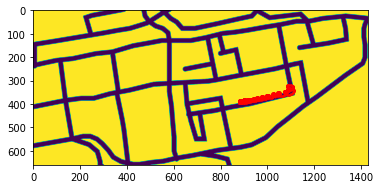

Sand  -2696 Non Sand -20.600000000000023


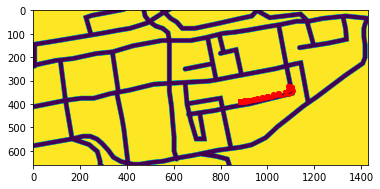

Sand  -7696 Non Sand -20.600000000000023


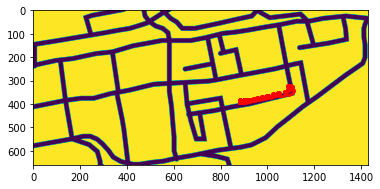

[-4.485683643860366, -5.0, -3.467584244822773, -5.0, -5.0, -4.67447334923448, -5.0, -5.0, -5.0, -4.483370395929841, -5.0, -5.0, -5.0, -5.0, -5.0, -4.46293156664411, -4.826952785597737, -4.560386495985024, -4.791876685621701, -4.542484456253139, -4.945719298102247, -5.0, -4.66446489083613, -5.0, -3.889893231556875, -4.998923564901667, -5.0, -5.0, -5.0, -5.0, -4.588886362777156, -5.0, -4.768674580223086, -4.994988692374382, -5.0, -5.0, -5.0, -5.0, -4.468373457998373, -5.0, -4.737712230334541, -4.16452736274187, -5.0, -5.0, -4.434607826076322, -4.980109912691622, -5.0, -5.0, -4.508828010309748, -5.0, -5.0, -5.0, -4.785660393560469, -4.247199896194038, -4.904167445111381, -5.0, -4.88197566505649, -4.354745675833291, -5.0, -5.0, -5.0, -3.9394208022826303, -4.7275751384870315, -5.0, -5.0, -4.588437403451136, -5.0, -4.98925907513838, -5.0, -4.741086140449391, -4.535893705678724, -4.349958008147106, -4.906419642598338, -5.0, -4.687501176248103, -4.79700280164924, -4.897147166775731, -4.5482847

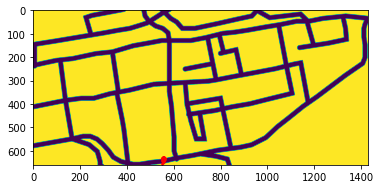

[-4.754174189323662, -3.9845477629183765, -5.0, -5.0, -4.666446763673079, -5.0, -4.283038703227378, -4.075711734354279, -4.2926694680713835, -5.0, -5.0, -5.0, -5.0, -4.698226355464865, -5.0, -5.0, -5.0, -5.0, -5.0, -4.171803356361096, -5.0, -4.737116323621426, -4.800838180455683, -4.440811758817822, -5.0, -4.709179997820389, -5.0, -5.0, -4.643871898533348, -5.0, -5.0, -5.0, -5.0, -4.309701972907965, -4.220408699388668, -5.0, -5.0, -4.844403676553175, -5.0, -5.0, -5.0, -5.0, -5.0, -4.843739384616459, -5.0, -3.987740145129081, -4.392363536248281, -4.13477487115676, -5.0, -5.0, -4.850342289044853, -5.0, -4.356140072420203, -5.0, -5.0, -5.0, -4.801193708986342, -4.932919523218553, -4.394443738550985, -5.0]
Total Timesteps: 122157 Episode Num: 20 Reward: -35.800000000000004
crashed 412.4488390942909 655.2699192612505


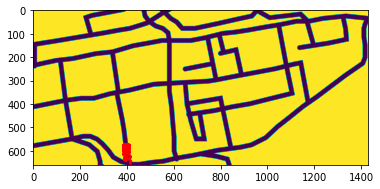

[-3.8520267803998713, -5.0, -5.0, -4.031985495702337, -5.0, -4.7530227183092135, -4.735883252279104, -5.0, -4.699073995761461, -5.0, -5.0, -5.0, -3.8697533240175463, -5.0, -4.692587972112413, -5.0, -4.800225716510791, -4.893265812309672, -5.0, -5.0, -4.6842116830283125, -5.0, -5.0, -4.810285813649683, -4.5743231666688615, -5.0, -5.0, -5.0, -5.0, -4.650677933546289, -4.98770596752916, -4.646518632419947, -5.0, -4.633163736531439, -4.543743666417974, -5.0, -4.654054967310576, -5.0, -5.0, -5.0, -4.729783815972982, -5.0, -5.0, -4.309448410052723, -5.0, -5.0, -4.013101537046276, -5.0, -5.0, -4.768553106589529, -5.0, -5.0, -4.757503450522515, -4.522610354460287, -5.0, -3.663440749994079, -5.0, -5.0, -4.6015314460959775, -5.0, -5.0, -4.554260370401608, -4.196923368532153, -4.610523321659703, -5.0, -4.974879748764847, -5.0, -5.0, -5.0, -5.0, -4.381438799672314, -4.707505596842235, -4.144683331974047, -4.748411423495972, -5.0, -3.92893750746481, -4.661222132823695, -5.0, -5.0, -5.0, -4.70600582

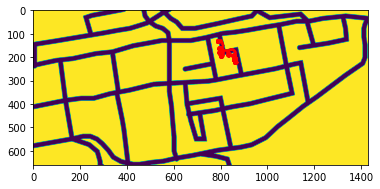

Sand  -1270 Non Sand -15.89999999999996


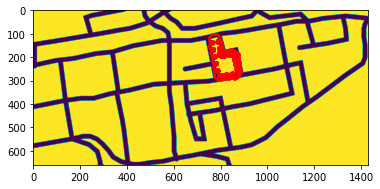

Sand  -5748 Non Sand -68.1000000000004


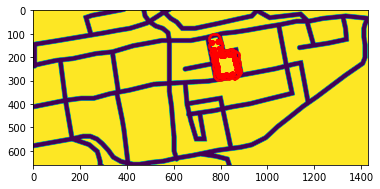

[-4.846833999047294, -4.68293896126261, -5.0, -4.919906934769472, -5.0, -5.0, -5.0, -5.0, -4.33481427992073, -5.0, -4.986961883010715, -5.0, -4.985139328734498, -5.0, -4.658985952831709, -5.0, -5.0, -4.757440042502951, -4.796368313317758, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.986335596737694, -4.738303850451151, -5.0, -5.0, -4.528102027295041, -5.0, -4.814011161923151, -5.0, -4.505214643977569, -5.0, -4.336639316580958, -5.0, -5.0, -5.0, -3.9522091511152238, -4.6535893175224405, -5.0, -5.0, -5.0, -5.0, -5.0, -4.100981561879031, -4.455530334544216, -4.980436819600955, -4.735612435366342, -4.709404663923564, -5.0, -5.0, -5.0, -5.0, -4.274003420810775, -4.528160790351876, -4.910294601468411, -4.458607972413903, -5.0, -5.0, -4.624486991120755, -4.908975384891372, -5.0, -4.950527730542253, -5.0, -5.0, -4.709612236894513, -4.873895965595743, -4.886760565761717, -4.891932211975686, -5.0, -4.772738043825873, -4.703204757474545, -4.9469581458496, -4.7075177808587725, -5.0, -4.24002726131533, -

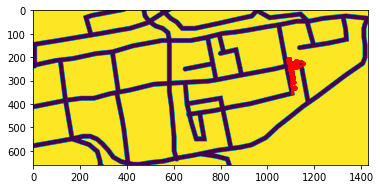

Sand  -1221 Non Sand -20.900000000000027


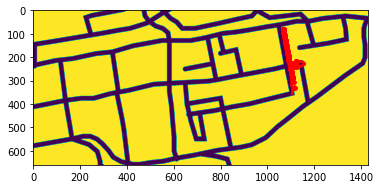

Sand  -6135 Non Sand -29.50000000000015


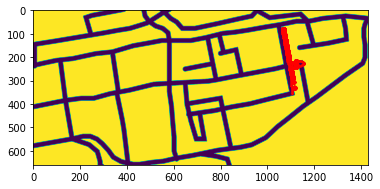

[-4.808103349933525, -5.0, -5.0, -3.8363904913533298, -4.784603523401032, -4.7838421138858065, -5.0, -5.0, -4.711278964854682, -5.0, -4.510526068012534, -4.202539229479478, -5.0, -5.0, -4.472827244528875, -5.0, -4.659857164558484, -4.335412549875077, -4.358275238287943, -5.0, -4.692847047909142, -4.24182096034044, -5.0, -5.0, -5.0, -4.889680545039457, -5.0, -5.0, -5.0, -4.850430895723119, -5.0, -5.0, -4.594705406787993, -5.0, -5.0, -4.976361680874224, -5.0, -4.916456305647707, -4.667176900838958, -4.1514175009205365, -4.473157707929277, -4.853690090925097, -5.0, -4.949492737606366, -4.875637163831837, -4.142343923613831, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.864131064496981, -5.0, -4.768061088695155, -5.0, -4.913874660841831, -4.703155802389789, -5.0, -5.0, -5.0, -4.493278298880155, -4.235694487585742, -4.7369620170387075, -4.155598201498038, -4.993719299179375, -4.579666164928899, -5.0, -4.483919755754667, -4.757880643538123, -5.0, -5.0, -4.076151748093524, -4.662693144175717, 

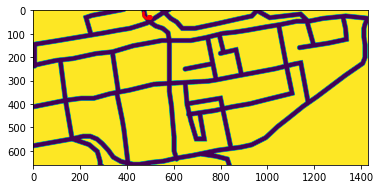

[-4.834531995471367, -4.875237321241684, -4.802468701852393, -4.68721185571757, -5.0, -4.657199480050204, -5.0, -5.0, -4.423945575341717, -4.693797184956608, -5.0, -4.596021559545646, -4.906537171243529, -4.439982742764954, -5.0, -4.8159783845363116, -4.9480633917308365, -5.0, -4.438234611309669, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.642009414608668, -5.0, -5.0, -4.231467051154066, -4.834162580429336, -5.0, -5.0, -5.0, -4.2369179833823285, -5.0, -4.999568432226006, -4.534071105522415, -5.0, -5.0, -4.861971191136265, -5.0, -4.2198368662658465, -4.953258076464872, -5.0, -4.21589500288829, -4.871626672941451, -4.878560404464072, -4.108956773135302, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -3.843612042436808, -5.0, -5.0, -5.0, -4.675056588184376, -5.0, -4.649890259616188, -4.032937557413469, -5.0, -4.892041934948588, -5.0, -5.0, -5.0, -4.894471227957432, -5.0]
Total Timesteps: 143640 Episode Num: 24 Reward: -43.50000000000002


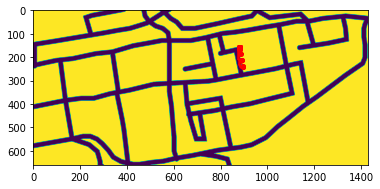

Sand  -1292 Non Sand -6.799999999999992


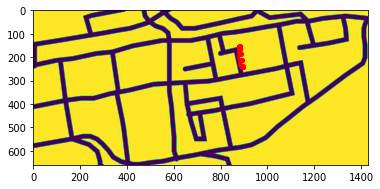

Sand  -6292 Non Sand -6.799999999999992


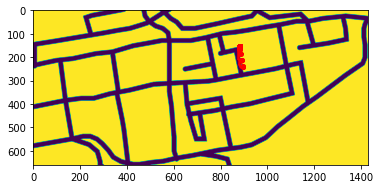

[-5.0, -5.0, -5.0, -4.004995172880825, -4.932681007718524, -5.0, -4.622116117846912, -4.913164549569005, -4.022217442771217, -5.0, -5.0, -5.0, -4.81546129015105, -4.864488187220953, -4.520850220747986, -4.583979981649764, -5.0, -4.588589990200051, -4.620370830052679, -3.43524245027196, -5.0, -4.959197198363447, -4.827488301831835, -5.0, -4.791675423297855, -5.0, -5.0, -5.0, -4.6435764851527805, -4.856521987788603, -5.0, -4.504817991851413, -5.0, -4.940751591878467, -4.966792233356609, -4.87756211193799, -4.926261593344457, -5.0, -5.0, -5.0, -4.260991582983513, -4.573965047167717, -4.357471412422555, -5.0, -4.809481768296887, -4.793158741409826, -5.0, -4.3278640139507125, -5.0, -3.8974434885685536, -4.64789526052985, -5.0, -5.0, -5.0, -4.364629545933203, -5.0, -5.0, -5.0, -3.778465406616224, -4.974012773436451, -5.0, -4.412965016951039, -4.761238174070012, -5.0, -5.0, -5.0, -5.0, -4.28095477756276, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.636275787673837, -5.0, -4.944735074381205, -

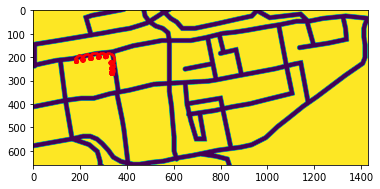

Sand  -1172 Non Sand -18.9


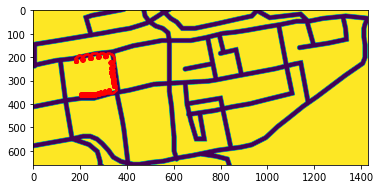

Sand  -6021 Non Sand -34.00000000000021


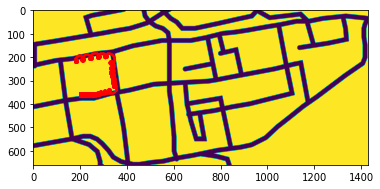

[-5.0, -4.271458385633261, -4.9534169695101244, -3.399542645441144, -5.0, -5.0, -3.9871142379314826, -5.0, -5.0, -4.391633825609015, -5.0, -5.0, -5.0, -4.9893046625401745, -4.625609462188405, -5.0, -4.964635429334293, -5.0, -4.563053096751808, -4.948213027134077, -4.964669689458045, -5.0, -4.602907737723855, -4.411668476818482, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.76149209943472, -4.6999930785507615, -4.651545001914679, -5.0, -5.0, -5.0, -4.329349778074781, -5.0, -5.0, -5.0, -5.0, -4.194480816702111, -5.0, -4.215049390912333, -4.045919252798934, -5.0, -5.0, -4.657626978911882, -4.8926715651715496, -4.076877319659434, -4.91679933895287, -4.964167255083032, -5.0, -4.929245299073676, -4.59661138645379, -5.0, -4.387147811468606, -5.0, -5.0, -5.0, -4.16430720049544, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.661956955304554, -4.686467356152746, -5.0, -4.233902931291912, -4.823207246131791, -4.872998833183238, -4.479080877857414, -4.696755789300525, -5.0, -4.6848491724916, -4

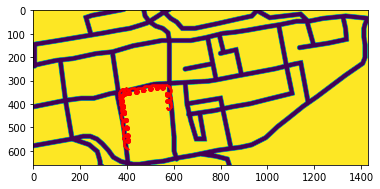

Sand  -914 Non Sand -44.80000000000037


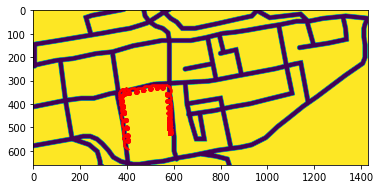

Sand  -5840 Non Sand -52.20000000000047


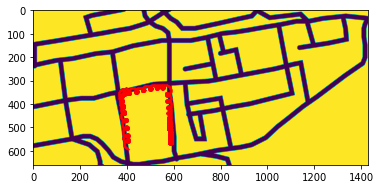

[-3.8520267803998713, -5.0, -5.0, -4.031985495702337, -5.0, -4.7530227183092135, -4.735883252279104, -5.0, -4.699073995761461, -5.0, -5.0, -5.0, -3.8697533240175463, -5.0, -4.692587972112413, -5.0, -4.800225716510791, -4.893265812309672, -5.0, -5.0, -4.6842116830283125, -5.0, -5.0, -4.810285813649683, -4.5743231666688615, -5.0, -5.0, -5.0, -5.0, -4.650677933546289, -4.98770596752916, -4.646518632419947, -5.0, -4.633163736531439, -4.543743666417974, -5.0, -4.654054967310576, -5.0, -5.0, -5.0, -4.729783815972982, -5.0, -5.0, -4.309448410052723, -5.0, -5.0, -4.013101537046276, -5.0, -5.0, -4.768553106589529, -5.0, -5.0, -4.757503450522515, -4.522610354460287, -5.0, -3.663440749994079, -5.0, -5.0, -4.6015314460959775, -5.0, -5.0, -4.554260370401608, -4.196923368532153, -4.610523321659703, -5.0, -4.974879748764847, -5.0, -5.0, -5.0, -5.0, -4.381438799672314, -4.707505596842235, -4.144683331974047, -4.748411423495972, -5.0, -3.92893750746481, -4.661222132823695, -5.0, -5.0, -5.0, -4.70600582

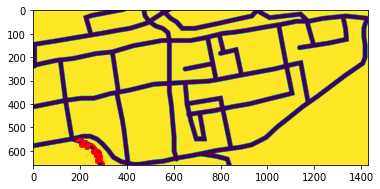

[-5.0, -4.528176955057371, -5.0, -4.9152739953717495, -4.350588175605831, -4.886383875087978, -4.549294407103735, -5.0, -4.842460321615388, -4.768667277570149, -4.949493793771786, -4.866314207110626, -4.772379323593374, -4.929013937501025, -5.0, -4.746225723896515, -5.0, -4.893692171464206, -4.367910536652791, -5.0, -4.844652155231195, -5.0, -4.053084966187557, -5.0, -4.711161130523203, -5.0, -4.171144430904969, -5.0, -4.65478726196728, -5.0, -4.8135935909028555, -5.0, -5.0, -4.89223539762794, -4.593591894705492, -4.576611280660032, -5.0, -4.533347215971536, -5.0, -5.0, -4.11297314153506, -5.0, -4.122176021045853, -4.7600648253001445, -5.0, -4.978767993180233, -5.0, -5.0, -4.753367651591668, -5.0, -5.0, -5.0, -4.803323714276615, -5.0, -5.0, -4.365865789246305, -4.951905615452743, -4.437442938905869, -5.0, -5.0, -5.0, -4.693742664527351, -5.0, -4.848225854574555, -5.0, -5.0, -4.039546181473239, -5.0, -5.0, -4.97685649221671, -4.532996782083741, -4.753711912725319, -5.0, -3.4067287331307

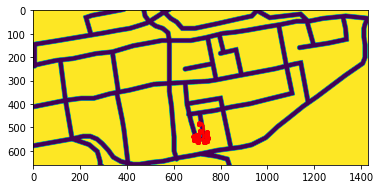

Sand  -721 Non Sand -23.000000000000057


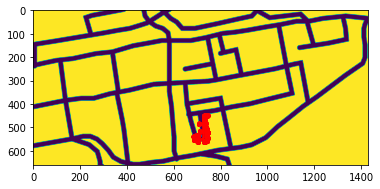

Sand  -5662 Non Sand -28.90000000000014


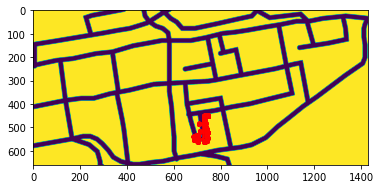

[-4.487648330499299, -4.689595169686452, -4.3781837701560695, -5.0, -3.9088674708694757, -5.0, -4.9109250392871155, -4.84292700238815, -4.941259522826854, -5.0, -5.0, -4.504312392687718, -5.0, -4.839806512435539, -5.0, -4.6761653385409305, -5.0, -5.0, -4.646068610732607, -5.0, -4.845242699263729, -4.331824530762184, -4.788151658913346, -4.950226691323743, -5.0, -5.0, -4.926933273689041, -4.8255672133624286, -5.0, -5.0, -4.549376231749312, -5.0, -5.0, -4.5450683767461335, -4.546521388311865, -4.116626545437354, -5.0, -4.151842092469323, -5.0, -4.745981678747317, -5.0, -4.91899868656283, -4.618515926656615, -5.0, -4.063503389824168, -4.959610135090887, -4.794014460472186, -4.064868632311138, -5.0, -4.901519774038018, -4.357745131629975, -5.0, -4.232600165701575, -5.0, -5.0, -5.0, -5.0, -5.0, -4.96139042346687, -4.514239348994741, -4.841938364753836, -4.954862956949832, -3.8202922957839736, -4.741710783590965, -4.568653350747925, -4.943545362849053, -5.0, -5.0, -4.971534306342309, -5.0, -

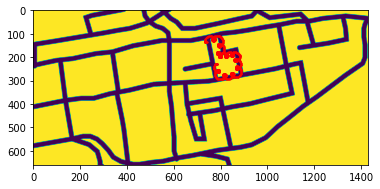

Sand  -590 Non Sand -36.200000000000244


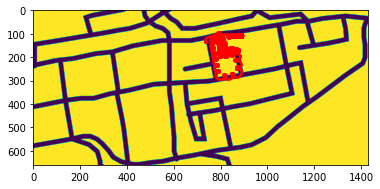

Sand  -4838 Non Sand -111.39999999999795


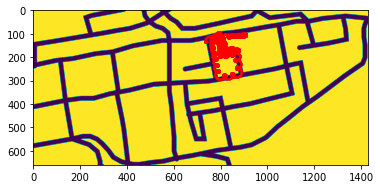

[-4.483590782966484, -5.0, -5.0, -4.37900333302668, -5.0, -4.482254640039406, -5.0, -5.0, -5.0, -4.852273365953866, -5.0, -4.888975736926868, -5.0, -4.307120237066944, -5.0, -4.4508242386222605, -4.694285734385414, -4.669661647817393, -5.0, -5.0, -5.0, -4.690652912274533, -4.8028408377584855, -4.544124509245186, -4.640476441241532, -5.0, -5.0, -5.0, -5.0, -4.540082882530999, -4.838975209490437, -5.0, -4.892866131741268, -4.496007911511892, -4.4671247539725325, -4.8959840293404655, -4.951513698961347, -4.910485098873817, -4.364839228250219, -5.0, -5.0, -4.405984817332155, -4.992854027476806, -4.769782396760481, -4.478130227769318, -5.0, -4.939196348325265, -5.0, -5.0, -4.7352847438924615, -4.186249445233721, -4.863063060214511, -4.374849304986798, -5.0, -4.712240019824773, -5.0, -4.962437916805382, -4.636771009867809, -5.0, -5.0, -5.0, -5.0, -4.978480131134826, -4.5952526675403895, -5.0, -5.0, -4.2974691025110365, -4.870809714770098, -4.052352250371801, -5.0, -4.798604230942452, -4.1164

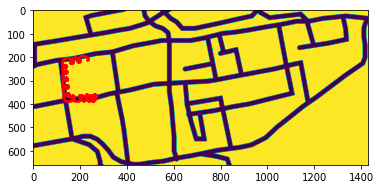

Sand  -599 Non Sand -35.40000000000023


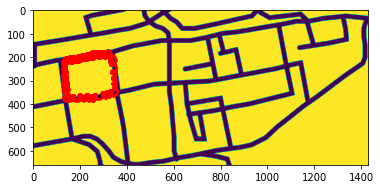

Sand  -4240 Non Sand -171.29999999999455


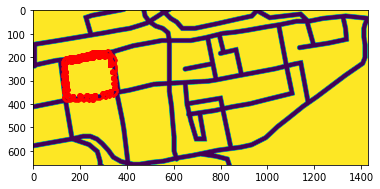

[-4.897174009522369, -4.7541347557944444, -5.0, -4.904631723002066, -5.0, -4.294032978575129, -4.904459205414256, -4.720369592011219, -4.747893001123967, -4.899646870449581, -5.0, -4.638625289244484, -5.0, -5.0, -5.0, -5.0, -4.523321575951015, -5.0, -4.863698117724732, -4.940688947252578, -4.460771229077084, -4.701942846313328, -5.0, -4.953465932094661, -5.0, -5.0, -4.783958192237676, -4.85905648563354, -4.8824567460069614, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.799803742728454, -5.0, -4.5345314970622015, -4.9287573617408045, -4.691559449661864, -5.0, -3.885357108325537, -4.3013859005350445, -4.928014252880498, -4.197805338725079, -5.0, -5.0, -3.776493591405476, -5.0, -5.0, -4.305471317770314, -5.0, -5.0, -5.0, -4.646677783365213, -4.166278212718682, -4.847552017791873, -5.0, -4.829812733674223, -4.351775845712499, -5.0, -5.0, -4.693785199640542, -5.0, -4.964966093293865, -4.753107164795562, -5.0, -4.292632220528278, -5.0, -5.0, -4.851450553489026, -5.0, -5.0, -5.0, -4.98953416863613, 

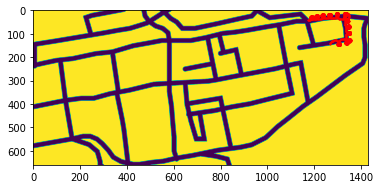

Sand  -654 Non Sand -30.000000000000156
crashed 1138.7547854071408 4.746441140837529


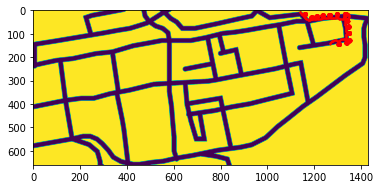

[-5.0, -5.0, -5.0, -4.892066963531748, -4.695176839171255, -5.0, -4.367146030071414, -4.902385083032436, -3.9405909979757974, -5.0, -5.0, -5.0, -5.0, -4.982777765334986, -4.144452811879062, -5.0, -5.0, -4.902861264519166, -5.0, -4.6872872180375245, -5.0, -4.2023306246194725, -4.634167343495654, -4.6963020892682135, -5.0, -4.810868013682236, -4.280346178427557, -4.966045731922349, -4.898966852887003, -5.0, -4.782608334650385, -4.598220780273265, -5.0, -4.500361388648489, -5.0, -4.689930125073602, -5.0, -4.847507833032293, -5.0, -4.928490126084647, -4.3573711413113445, -5.0, -4.978798134020994, -4.955850463418188, -5.0, -5.0, -5.0, -5.0, -4.79932606252242, -4.733038504506487, -4.74697244725248, -5.0, -5.0, -5.0, -4.735265941562257, -5.0, -4.55548150819841, -5.0, -5.0, -4.641736510501283, -5.0, -5.0, -4.625385529272406, -4.401196579323372, -5.0, -4.926996029226355, -5.0, -4.819608495688084, -4.082609278249652, -4.591520511951427, -5.0, -4.783959402248999, -5.0, -5.0, -4.015633699204575, -

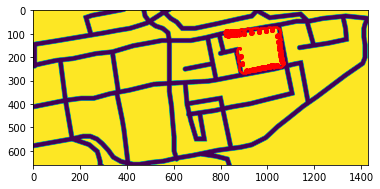

Sand  -4321 Non Sand -58.90000000000057


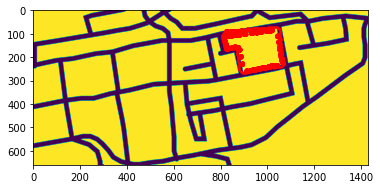

Sand  -9091 Non Sand -81.89999999999962


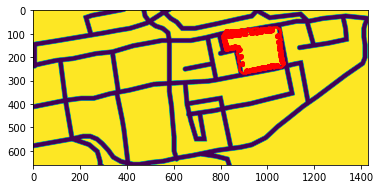

[-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.732855484604666, -4.7347449399520425, -4.961377512763174, -4.9872776648585635, -4.271846999900703, -4.942265912360761, -4.7716348693334645, -4.23712724286584, -4.254118832623627, -4.851610839700005, -4.813885188654721, -5.0, -5.0, -4.386114928250617, -5.0, -5.0, -5.0, -4.8514408107244265, -5.0, -5.0, -5.0, -5.0, -5.0, -4.680773232250396, -5.0, -5.0, -4.530263030245121, -4.900032122670062, -5.0, -4.548210047505279, -5.0, -4.876989105748019, -4.94936117417573, -5.0, -4.5694356118701505, -4.872906464435507, -4.997170834305423, -4.931161829253508, -4.89126923625833, -4.211788891022441, -4.967212051029558, -5.0, -4.8766085390409035, -5.0, -4.71939868520939, -5.0, -3.891418597861311, -4.9947855982256675, -5.0, -5.0, -5.0, -4.592801580876165, -4.919564714078681, -5.0, -5.0, -5.0, -4.654391095646838, -5.0, -5.0, -5.0, -5.0, -4.096481412496937, -4.78936871427566, -4.879093669661006, -4.921759658989354, -5.0, -3.7183123144934958, -5.0, -4.61009776791954, -

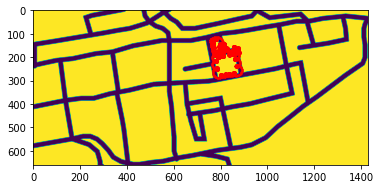

Sand  -3871 Non Sand -103.99999999999837


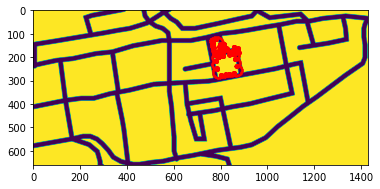

Sand  -8871 Non Sand -103.99999999999837


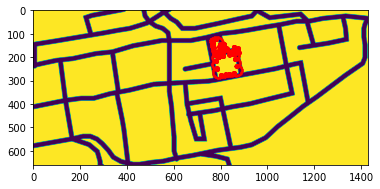

[-5.0, -5.0, -5.0, -4.8271851930588765, -5.0, -4.935962539201089, -4.4625851372657, -5.0, -5.0, -4.964137662556493, -5.0, -5.0, -4.973542367201482, -4.482176475002687, -5.0, -3.637253396012813, -5.0, -5.0, -4.938781714755051, -4.820697290453342, -4.652063058194938, -4.964186325373057, -4.025995506893715, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -4.090061069317972, -4.952110547507208, -5.0, -4.807458041755624, -4.835194578532578, -4.554671993267625, -5.0, -4.760772664727583, -5.0, -4.6253953309919735, -5.0, -5.0, -5.0, -5.0, -5.0, -4.546379166238756, -4.9050863695244225, -4.9369431796480745, -5.0, -5.0, -4.6940320879161375, -4.5081837532438955, -5.0, -5.0, -5.0, -5.0, -5.0, -4.978544065561688, -5.0, -5.0, -5.0, -5.0, -5.0, -4.696870513915334, -5.0, -4.9116525490255665, -5.0, -5.0, -4.400892672468622, -5.0, -5.0, -4.242688148816285, -3.8142555263939784, -4.939496582851292, -4.398499669087406, -5.0, -5.0, -5.0, -4.721741859165559, -4.838970611815997, -3.7433346359979067, -4.9941241301922465, -

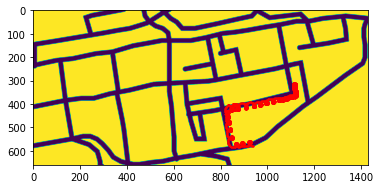

Sand  -4423 Non Sand -48.900000000000425


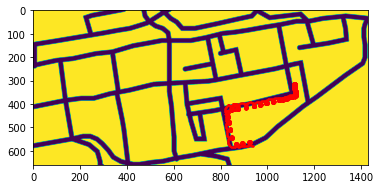

Sand  -9423 Non Sand -48.900000000000425


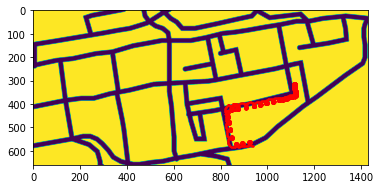

[-5.0, -4.761397822981213, -4.567305790071929, -5.0, -5.0, -5.0, -4.350899477683468, -4.527434501476836, -4.755432848229965, -5.0, -4.702091693580684, -5.0, -4.648141915723436, -4.346897763112531, -5.0, -5.0, -5.0, -5.0, -4.232557106551346, -5.0, -5.0, -5.0, -4.744635881998167, -4.97770126188702, -5.0, -5.0, -4.884643015927661, -5.0, -4.111330381563981, -4.567019084527495, -5.0, -5.0, -4.591794975140226, -4.311688502977842, -5.0, -5.0, -5.0, -5.0, -5.0, -4.9003471109520484, -5.0, -5.0, -4.818620890081302, -5.0, -5.0, -4.871927093770797, -4.181792395590791, -4.744225578028681, -5.0, -5.0, -5.0, -5.0, -5.0, -4.648361714899723, -4.678412492390233, -5.0, -5.0, -5.0, -5.0, -5.0, -4.840480608279201, -5.0, -4.340372016916728, -4.9519851046333985, -5.0, -5.0, -5.0, -4.699716889626357, -4.1701309095900845, -5.0, -4.384006074157568, -4.451118485731149, -4.6254938243304, -3.7877374112731585, -5.0, -4.325800623355697, -5.0, -5.0, -5.0, -4.83230442730101, -5.0, -4.6133948049357665, -4.5956473720782

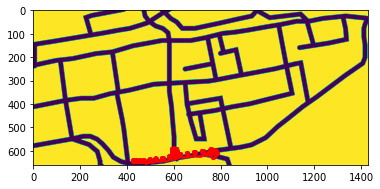

Sand  -4345 Non Sand -56.80000000000054


In [0]:
max_timesteps = 500000
# We start the main loop over 500,000 timesteps
actions = []
while total_timesteps < max_timesteps:
    if(total_timesteps % 5000 == 0):
      env.plotData()
      env.printRewardDistribution()
    # If the episode is done
    if done:
        env.resetInfo()
        print(actions)
        actions = []
        # If we are not at the very beginning, we start the training process of the model
        if total_timesteps != 0:
            print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
            policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

        # We evaluate the episode and we save the policy
        if timesteps_since_eval >= eval_freq:
          timesteps_since_eval %= eval_freq
          policy.save(file_name, directory="./pytorch_models")


        # When the training step is done, we reset the state of the environment
        obs, obs1 = env.reset()
        # Set the Done to False
        done = False

        # Set rewards and episode timesteps to zero
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    #Before 10000 timesteps, we play random actions
    if total_timesteps < start_timesteps:
        action = env.sample()
    else: # After 10000 timesteps, we switch to the model
        action = policy.select_action(obs, obs1)
        #If the explore_noise parameter is not 0, we add noise to the action and we clip it
        if expl_noise != 0:
            action = (action + np.random.normal(0, expl_noise, size=action_dim)).clip(env.low, env.high)
        action = action[0]
    actions.append(action)
    # The agent performs the action in the environment, then reaches the next state and receives the reward    
    new_obs, new_obs1, reward, done, _ = env.step(action)

    # We check if the episode is done
    done_bool = 0 if episode_timesteps + 1 == env._max_episode_steps else float(done)

    # We increase the total reward
    episode_reward += reward
    
    # We store the new transition into the Experience Replay memory (ReplayBuffer)
    replay_buffer.add((obs, new_obs, obs1, new_obs1, action, reward, done_bool))

    # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
    obs = new_obs
    obs1 = new_obs1
    episode_timesteps += 1
    total_timesteps += 1
    timesteps_since_eval += 1

    if(episode_timesteps +1 == env._max_episode_steps):
      env.plotData()
      done = True
      
# We add the last policy evaluation to our list of evaluations and we save our model
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")